## Import Data

In [238]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_raw = pd.read_csv('spy.csv')

In [239]:
df_raw.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year
0,1993-01-29,25.236158,25.236158,25.110605,25.218222,1003200,29,4,4,1,1993
1,1993-02-01,25.236146,25.397572,25.236146,25.397572,480500,1,0,5,2,1993
2,1993-02-02,25.379673,25.469354,25.325865,25.451418,201300,2,1,5,2,1993
3,1993-02-03,25.487270,25.738376,25.469334,25.720440,529400,3,2,5,2,1993
4,1993-02-04,25.810132,25.881876,25.523153,25.828068,531500,4,3,5,2,1993


In [240]:
df_raw['avg'] = (df_raw['High'] + df_raw['Low']) / 2 

df_raw.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,avg
0,1993-01-29,25.236158,25.236158,25.110605,25.218222,1003200,29,4,4,1,1993,25.173381
1,1993-02-01,25.236146,25.397572,25.236146,25.397572,480500,1,0,5,2,1993,25.316859
2,1993-02-02,25.379673,25.469354,25.325865,25.451418,201300,2,1,5,2,1993,25.397609
3,1993-02-03,25.487270,25.738376,25.469334,25.720440,529400,3,2,5,2,1993,25.603855
4,1993-02-04,25.810132,25.881876,25.523153,25.828068,531500,4,3,5,2,1993,25.702515


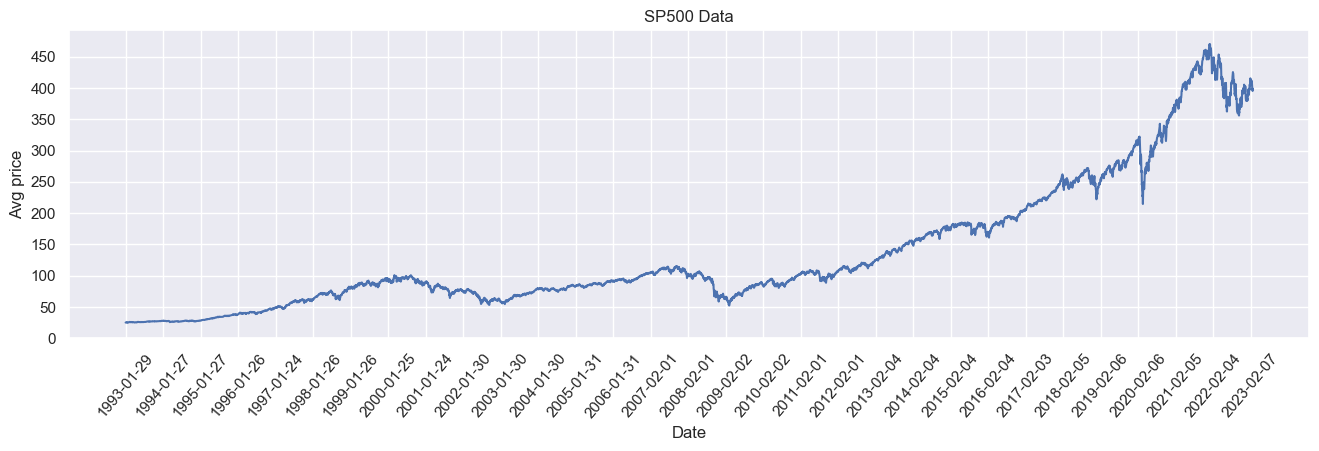

In [241]:
import seaborn as sns

sns.set(rc={'figure.figsize':(16, 4)})
ax = sns.lineplot(x=df_raw['Date'], y=df_raw['avg'])
ax.set_xticks(range(0, len(df_raw), int(len(df_raw)/30))) 
ax.set_yticks(range(0, 500, 50))
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(rotation=50)
plt.show()

## LSTM

In [242]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [243]:
def rmse_calc(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse

def mape_calc(y_true, y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

In [244]:
split = int(len(df_raw)*.8)

x = df_raw.drop(['avg', 'Day', 'Week', 'Month'], axis=1)
y = df_raw['avg']
y = y.values.reshape(-1,1)

x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

test_dates = x_test['Date']
x_test = x_test.drop('Date', axis=1)
x_train = x_train.drop('Date', axis=1)

In [245]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

In [246]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

In [247]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
pred_array = []
mse_array = []

model_count = 10

for i in range(model_count):
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=(x_test, y_test), callbacks=[early_stop], shuffle=False, verbose=0)
    y_pred = model.predict(x_test)
    mse = np.mean((y_pred - y_test)**2)
    pred_array.append(y_pred)
    if(i > 0):
        if(mse < min(mse_array)):
            best_pred = y_pred
    mse_array.append(mse)


Epoch 1/100
61/61 [==============================] - 2s 7ms/step - loss: 0.0146 - val_loss: 0.2014
Epoch 2/100
61/61 [==============================] - 0s 3ms/step - loss: 0.0134 - val_loss: 0.0751
Epoch 3/100
61/61 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0137
Epoch 4/100
61/61 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 5/100
61/61 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 3.9664e-04
Epoch 6/100
61/61 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 9.2380e-04
Epoch 7/100
61/61 [==============================] - 0s 3ms/step - loss: 7.5965e-04 - val_loss: 0.0015
Epoch 8/100
61/61 [==============================] - 0s 3ms/step - loss: 5.6327e-04 - val_loss: 0.0017
Epoch 9/100
61/61 [==============================] - 0s 3ms/step - loss: 4.4032e-04 - val_loss: 0.0017
Epoch 10/100
48/48 [==============================] - 0s 700us/step
Epoch 1/100
61/61 [==

In [248]:
best_pred_inv = scaler_y.inverse_transform(best_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

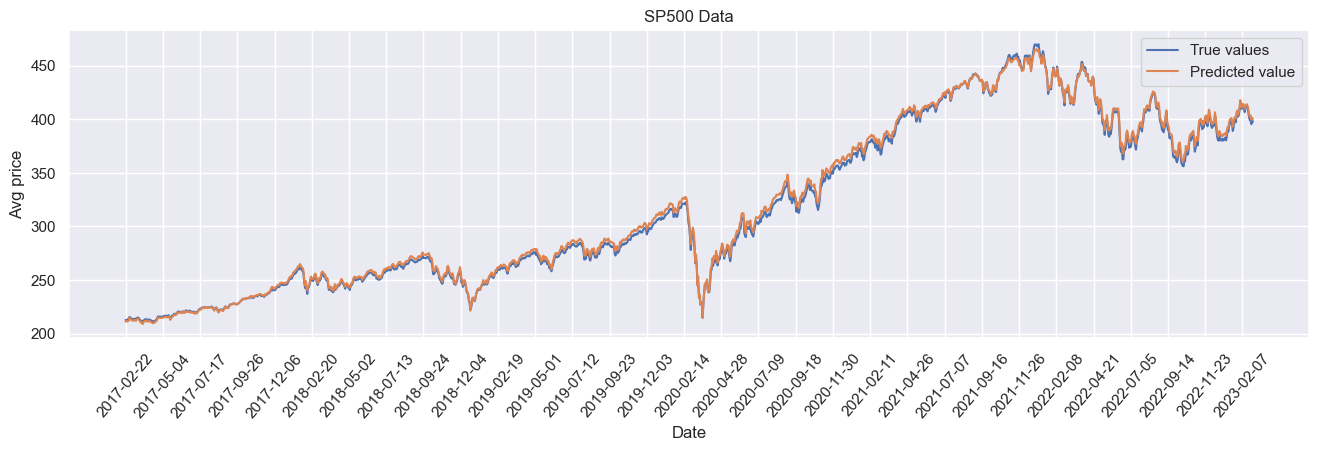

In [249]:
sns.set(rc={'figure.figsize':(16, 4)})
ax = sns.lineplot(x=test_dates, y=y_test_inv.flatten(), label='True values')
ax.set_xticks(range(0, len(test_dates), int(len(test_dates)/30))) 
ax.set_yticks(range(0, 500, 50))
sns.lineplot(x=test_dates, y=best_pred_inv.flatten(), label=f'Predicted value')
plt.legend()
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(rotation=50)
plt.show()